In [2]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import pickle
import os

from pathlib import Path
from datetime import datetime

# Plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# SKLEARN
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler

# from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.impute import KNNImputer

from imblearn.over_sampling import RandomOverSampler

# stats models
import statsmodels.api as sm
from scipy import stats

# Printint output
from IPython.core.interactiveshell import InteractiveShell

## Import + Prep Data
---

In [3]:
# Import Data
# ---------------------
df = pd.read_csv("../data/cleaned/not_scaled_no_missing.csv")
# df = pd.read_csv("data/cleaned/not_scaled_with_missing.csv")

In [24]:
# SETUP DATAFRAMES. CALCULATE OUTCOME METRIC DELTAS
# ---------------------
# Make adjustments to our DataFrames + Targets
df_targets = df[[
    'cluster2019_base', 'study_group',
    'api_tot_recode0_4_base', 'csigimn2019_base', 'cprinterf8_base', 'cprint8_tscore_base',
    'api_tot_recode0_4_post', 'csigimn2019_post', 'cprinterf8_post', 'cprint8_tscore_post',
    ]]

df = df.drop(
    ['api_tot_recode0_4_base', 'csigimn2019_base', 'cprinterf8_base', 'cprint8_tscore_base',
     'api_tot_recode0_4_post', 'csigimn2019_post', 'cprinterf8_post', 'cprint8_tscore_post'], 
    axis = 1
)

# Keep study group (treatment). Remove FAP Subgroup
df = df.drop('cluster2019_base', axis=1)

# Calculate our delta
df_targets['api_delta'] = df_targets['api_tot_recode0_4_post'] - df_targets['api_tot_recode0_4_base']
df_targets['csigi_delta'] = df_targets['csigimn2019_post'] - df_targets['csigimn2019_base']
df_targets['cprinterf8_delta'] = df_targets['cprinterf8_post'] - df_targets['cprinterf8_base']



In [26]:
def round_to(n, precision):
    correction = 0.5 if n >= 0 else -0.5
    return int( n/precision+correction ) * precision

def round_to_05(n):
    return round_to(n, 0.5)

In [25]:
# Split out target + dataframe
X_data = df.copy()

In [27]:
X_data['age_consent'] = df['age_consent'].apply(lambda x: round_to_05(x))

In [28]:
X_data.drop(['dose', 'teen_module'], axis=1, inplace=True, errors = 'ignore')

### Jacobson RCI
---
Jacobson Clinical Signifiance / Reliable Change Index [link]()

Calcuate it two ways. Varying definintions on how to calculate. Chronbach Alpha scores were provided
* RCI 1 -- https://lbecker.uccs.edu/clinsig
* RCI 2 -- https://www.psyctc.org/stats/rcsc1.htm

In [29]:
def calculate_rci(data, method = 1):
    """
    Was unable to find a consistent defintion on how to derive RCI.
    Implemented multiple methods below with their sources.
    Methods 1 + 3 should return the same result
    """

    # https://www.psyctc.org/stats/rcsc1.htm
    if method == 1:
        std_error_change = data['baseline']['stdev'] * math.sqrt(2) * math.sqrt(1-data['baseline']['cron_alpha'])
    
    # https://teaching.psy.uq.edu.au/tools/statsrepo/?download=927
    # SE_diff calculation (slide 4)
    elif method == 2:
        std_error_change = data['baseline']['stdev'] * \
        math.sqrt(2 - data['baseline']['cron_alpha'] - data['post']['cron_alpha'])

    # Same link, SEM calcuation (slide 4)
    elif method == 3:
        sem = data['baseline']['stdev'] * math.sqrt(1-data['baseline']['cron_alpha'])
        std_error_change = math.sqrt(2 * sem**2)
    
    return std_error_change * 1.96

In [30]:
# Standard deviation (stdev) was calculated from the 184 records after dropping all nulls
# cronbach alpha scores were pulled from "Reliability_WebMAP_05162019"
data_metrics = {
    'api': {
        'baseline': {
            'cron_alpha': 0.79,
            'stdev': 0.922259
        },
        'post': {
            'cron_alpha': 0.88,
            'stdev': 0.9474
        }
    },
    'csi_gi': {
        'baseline': {
            'cron_alpha': 0.72,
            'stdev': 0.75592
        },
        'post': {
            'cron_alpha': 0.80,
            'stdev': 0.73399
        }
    },
    'promis': {
        'baseline': {
            'cron_alpha': 0.89,
            'stdev': 7.4225
        },
        'post': {
            'cron_alpha': 0.92,
            'stdev': 7.1835
        }
    }
}

In [31]:
# RCI Target Variables
df_targets['api_rci_1'] = df_targets['api_delta'].abs() > calculate_rci(data_metrics['api'], method=1)
df_targets['api_rci_2'] = df_targets['api_delta'].abs() > calculate_rci(data_metrics['api'], method=2)

df_targets['csigi_rci_1'] = df_targets['csigi_delta'].abs() > calculate_rci(data_metrics['csi_gi'], method=1)
df_targets['csigi_rci_2'] = df_targets['csigi_delta'].abs() > calculate_rci(data_metrics['csi_gi'], method=2)

df_targets['promis_rci_1'] = df_targets['cprinterf8_delta'].abs() > calculate_rci(data_metrics['promis'], method=1)
df_targets['promis_rci_2'] = df_targets['cprinterf8_delta'].abs() > calculate_rci(data_metrics['promis'], method=2)

In [32]:
# Number of significantly changed results by FAP subgroup
# 1 -- HDP, 2 -- HPA, 3 -- LPA
df_targets[['cluster2019_base', 'api_rci_1', 'csigi_rci_1', 'promis_rci_1']]\
.groupby('cluster2019_base').sum().reset_index()

,cluster2019_base,api_rci_1,csigi_rci_1,promis_rci_1
0,1,29,21,34
1,2,24,14,22
2,3,9,3,1


## Logistic Regression
---

Doing a simple logistic regression with a test/train split. We'll do 25 iterations and report on the average.

Iterations of this below:

* All Features -- No regularization
* All Features -- Lasso Regularization (L2)
* Regression Top features


**Summary of Results**
<br>
The first 2 (two) iterations were not very promsing -- Overall accuracy was at the highest around 60% withe precision and recall in the mid-30s. Over multiple iterations, oversampling the class with significant change (outcome variable = 1) showed similar results.

Finally when limiting to the top features from our regression analysis (27 in total) we see an improvement across the board (accuracy ~62%, precision ~45%, recall ~53%). These numbers still leave something to be desired, however and would not cut it if used in production or clinical setting.

### Iteration 1 - All Features (L2 Regularization)
---

To get a baseline we are only performing this for API outcome variable

In [33]:
# outcome variable
outcome_variable = 'api_rci_1'

# number of loops
count_iters = 50

# store results for each iteration
recall = []
precision = []
accuracy = []

In [34]:
pipe = Pipeline([
                ("scaler", MinMaxScaler()),
                ("reg", LogisticRegression(penalty = 'l2'))
            ])

In [37]:
for i in range(count_iters):

    ## Test/Train Split
    X_train, X_test, y_train, y_test = train_test_split(X_data, 
                                                        df_targets[outcome_variable],
                                                        test_size=0.25)
    
    # Training
    pipe.fit(X_train, y_train);

    # Predictions
    predictions = pipe.predict(X_test)

    # Calcuate + Store Metrics
    accuracy.append(accuracy_score(y_test, predictions))
    precision.append(precision_score(y_test, predictions))
    recall.append(recall_score(y_test, predictions))

In [38]:
# Average Result Metrics
print(f'Accuracy: {round(np.mean(accuracy), 3)}')
print(f'Precision: {round(np.mean(precision), 3)}')
print(f'Recall: {round(np.mean(recall), 3)}')

Accuracy: 0.621
Precision: 0.394
Recall: 0.285


### Iterration 2 - All Features (No Regularization)

In [39]:
outcome_variable = 'api_rci_1'

count_iters = 50

recall = []
precision = []
accuracy = []

In [40]:
pipe = Pipeline([
                ("scaler", MinMaxScaler()),
                ("reg", LogisticRegression(penalty = 'none'))
            ])

In [41]:
for i in range(count_iters):

    ## Test/Train Split
    X_train, X_test, y_train, y_test = train_test_split(X_data, 
                                                        df_targets[outcome_variable],
                                                        test_size=0.25)
    
    # Training
    pipe.fit(X_train, y_train);

    # Predictions
    predictions = pipe.predict(X_test)

    # Calcuate + Store Metrics
    accuracy.append(accuracy_score(y_test, predictions))
    precision.append(precision_score(y_test, predictions))
    recall.append(recall_score(y_test, predictions))

In [42]:
# Average Result Metrics
print(f'Accuracy: {round(np.mean(accuracy), 3)}')
print(f'Precision: {round(np.mean(precision), 3)}')
print(f'Recall: {round(np.mean(recall), 3)}')

Accuracy: 0.553
Precision: 0.365
Recall: 0.364


### Iteration 3 -- All features with Oversampling

In [43]:
outcome_variable = 'api_rci_1'

count_iters = 50

recall = []
precision = []
accuracy = []

In [44]:
pipe = Pipeline([
                ("scaler", MinMaxScaler()),
                ("reg", LogisticRegression(penalty = 'none'))
            ])

In [ ]:
for i in range(count_iters):

    ## Test/Train Split
    X_train, X_test, y_train, y_test = train_test_split(X_data, 
                                                        df_targets[outcome_variable],
                                                        test_size=0.25)
    
    # Oversample clinically significant cases
    ros = RandomOverSampler(random_state=0)
    X_train, y_train = ros.fit_resample(X_train, y_train)

    # Training
    pipe.fit(X_train, y_train);

    # Predictions
    predictions = pipe.predict(X_test)

    # Calcuate + Store Metrics
    accuracy.append(accuracy_score(y_test, predictions))
    precision.append(precision_score(y_test, predictions))
    recall.append(recall_score(y_test, predictions))

In [47]:
# Average Result Metrics
print(f'Accuracy: {round(np.mean(accuracy), 3)}')
print(f'Precision: {round(np.mean(precision), 3)}')
print(f'Recall: {round(np.mean(recall), 3)}')

Accuracy: 0.565
Precision: 0.365
Recall: 0.354


### Iteration 4 -- Top 10 Features

In [53]:
outcome_variable = 'api_rci_1'
count_iters = 50

recall = []
precision = []
accuracy = []

In [54]:
# Columns (Top 10 -- 27 total + study_group)!
# ---------------------
col_subset_10 = list({
    'fdi9_txfap', 'fdi12_txfap', 'fdi13_txfap', 'csi10_txfap', 'prsleep4_txfap', 
    'fdi5_txfap', 'pbq10_txfap', 'prsleep7_txfap', 'csi21_txfap', 'pbq12_txfap', 
    'csi13_txfap', 'csi21_txfap', 'csi12_txfap', 'csi15_txfap', 'api4_txfap', 'csi14_txfap', 
    'csi20_txfap', 'csi23_txfap', 'csi17_txfap', 'promis_anx5_txfap', 'api1_txfap', 'api2_txfap', 
    'api3_txfap', 'age_consent', 'fdi8_txfap', 'csi15_txfap', 'pbq16_txfap', 'api4_txfap', 
    'cdi18_txfap', 'csi8_txfap'})


# Get Data Subset
# ---------------------
X_data_subset_10 = X_data[col_subset_10]

In [55]:
pipe = Pipeline([
                ("scaler", MinMaxScaler()),
                ("reg", LogisticRegression(penalty = 'l2'))
            ])

In [56]:
for i in range(count_iters):

    ## Test/Train Split
    X_train, X_test, y_train, y_test = train_test_split(X_data_subset_10, # updated here 
                                                        df_targets[outcome_variable],
                                                        test_size=0.25)
    
    # Oversample clinically significant cases
    ros = RandomOverSampler(random_state=0)
    X_train, y_train = ros.fit_resample(X_train, y_train)

    # Training
    pipe.fit(X_train, y_train);

    # Predictions
    predictions = pipe.predict(X_test)

    # Calcuate + Store Metrics
    accuracy.append(accuracy_score(y_test, predictions))
    precision.append(precision_score(y_test, predictions))
    recall.append(recall_score(y_test, predictions))

In [52]:
# Average Result Metrics
print(f'Accuracy: {round(np.mean(accuracy), 3)}')
print(f'Precision: {round(np.mean(precision), 3)}')
print(f'Recall: {round(np.mean(recall), 3)}')

Accuracy: 0.616
Precision: 0.451
Recall: 0.525


# Random Forest Classification

## Functions
Classifications-specific versions of the other notebook's code. Not calculating model metrics separately

In [58]:
def rf_bootstrap_classification(n, k, param_grid, seeds, target_field, pipe, 
                 target_data, X_data, samples=None, error = 'mae',
                 impute_knn = False, oversample = False):
    """
    n: Number of loops / iterations
    k: cross-folds
    seeds: list of seeds for resampling
    target_fields: target variable
    target_data: target data + other data (subgroup, treatment, etc)
    X_data: predictors

    Returns
    ----
    model_store: list. Best model from each iteration. Includes feature importance
    model_results: mae, var, median mae for each iteration.
    """
    pd.set_option('mode.chained_assignment',None)

    model_store = []
    saved_predictions = pd.DataFrame()

    # MODEL LOOP
    # OUTER LOOOP - OOB BOOSTRAP
    for outer_loop in range(n):
        X_train, y_data = resample(X_data, target_data, replace = True, 
                                    n_samples = samples, random_state = seeds[outer_loop])
        
        y_train = y_data[target_field]
        
        # INNER LOOP - K-FOLD CV (GRID SEARCH)
        # Define socring based on metric
        gs = RandomizedSearchCV(
              pipe, 
              param_distributions = param_grid, 
              cv = k,
              n_jobs=-1)
    
        gs.fit(X_train, y_train)
        
        # store best model
        best_model = gs.best_estimator_.named_steps['clf']  # this is the same
        model_store.append(best_model)

        # Get best model params
        best_params = best_model.get_params()
        best_params['oob_score'] = True
        
        # fit full dataset
        # IMPUTE VALUES AS NEEDED
        if impute_knn:
            imputer = KNNImputer(n_neighbors=impute_knn)
            x_train_impute = imputer.fit_transform(X_train)

            X_train = pd.DataFrame(
                data = x_train_impute,
                columns = X_train.columns.values,
                index = X_train.index.values   
            )

        rf_best = RandomForestClassifier(**best_params)
        rf_best.fit(X_train, y_train)
        
        class_results = rf_best.oob_decision_function_
        
        # Class 1 weights (sigmoid) -- Was there sig change?
        # Because binary classification we don't need to store both (sum to 1)
        y_data['predict_changed'] = class_results[:, 1]

        saved_predictions = \
          pd.concat([saved_predictions, 
                      y_data[['cluster2019_base', 'study_group', target_field, 'predict_changed']]
          ])

    return model_store, saved_predictions


In [59]:
def classification_outer_loop(outcome_list, 
                              X_data,
                              target_df, 
                              sub_folder,
                              param_grid,
                              seeds,
                              knn_neighbors = 0,
                              oversample = False
                              ):

    for target in outcome_list:
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print(f'starting on: {target} --- {current_time}')

        # Get subset of target data!
        target_data = df_targets[[target, 'study_group', 'cluster2019_base']].copy()

        # Folder to save results
        save_folder = f'{sub_folder}/' + target
        
        if knn_neighbors == 0:
            knn_neighbors = False
            pipe = Pipeline([
                ("clf", RandomForestClassifier()),
            ])
        else:
            pipe = Pipeline([
                ('knn_impute', KNNImputer(n_neighbors=knn_neighbors)),
                ("clf", RandomForestClassifier())
            ])

        # run modeling
        model_store, preds = \
            rf_bootstrap_classification(
                n = n, 
                k = k, 
                param_grid = param_grid, 
                seeds = seeds, 
                target_field = target, 
                target_data = target_data, 
                X_data = X_data,
                error = 'gini',
                pipe = pipe,
                impute_knn = knn_neighbors)

        # SAVE DATA
        # ---------------------------

        # create folder if not exist
        Path(f'data/{save_folder}').mkdir(parents=True, exist_ok=True)

        # model store
        with open(f"data/{save_folder}/model_store.pickle", "wb") as ms:
            pickle.dump(model_store, ms)

        # predictions
        with open(f"data/{save_folder}/predictions.txt", "wb") as pred:
            pickle.dump(preds, pred)

    return

In [160]:
def fap_classification_results(df_predictions, decimals = 4):
    results = {
        'overall': {},
        'hpd': {},
        'hpa': {},
        'lpa': {}
    }

    # subgroups
    subgroups = ['hpd', 'hpa', 'lpa']

    # Overall
    results['overall']['accuracy'] = \
        accuracy_score(df_predictions[outcome_var], df_predictions['result_threshold']).round(decimals)
    
    results['overall']['precision'] = \
        precision_score(df_predictions[outcome_var], df_predictions['result_threshold']).round(decimals)

    results['overall']['recall'] = \
        recall_score(df_predictions[outcome_var], df_predictions['result_threshold']).round(decimals)

    results['overall']['f1'] = \
        f1_score(df_predictions[outcome_var], df_predictions['result_threshold']).round(decimals)


    for idx, value in enumerate(subgroups):
        df_filtered = df_predictions.loc[df_predictions.cluster2019_base == (idx+1)]

        results[value]['accuracy'] = \
            accuracy_score(df_filtered[outcome_var], df_filtered['result_threshold']).round(decimals)

        results[value]['precision'] = \
            precision_score(df_filtered[outcome_var], df_filtered['result_threshold']).round(decimals)

        results[value]['recall'] = \
            recall_score(df_filtered[outcome_var], df_filtered['result_threshold']).round(decimals)
        
        results[value]['f1'] = \
            f1_score(df_filtered[outcome_var], df_filtered['result_threshold']).round(decimals)

    return results

## Part 1 - All Features
---

Implement our binary classificataion using all features available in our dataset

### Model Parameters

In [60]:
# MODEL SETUP
n = 50              # OUTER LOOP ITERATIONS (down from 100)
k = 3               # cross-folds
knn_neighbors = 0

seeds = np.random.randint(10000, size = n)

# Looping through targets
outcomes = ['api_rci_1', 'csigi_rci_1', 'promis_rci_1']

# Parameter grid
param_grid = {
    "clf__n_estimators": [50, 80, 100, 120, 150],
    "clf__max_depth": [3, 4, 5, 6, 10],
    "clf__max_features": [*np.arange(0.10, 0.80, 0.05)],
    "clf__min_samples_split": [3, 5, 10, 15, 20, 40, 50],
    "clf__min_samples_leaf": [2, 3, 4, 5] # guarantees a min number of samples in every leaf
}

### Model Loop

In [61]:
# classification_outer_loop

# RANDOM FEATURES
sub_folder = 'binary_classification/all_features'

classification_outer_loop(
    
    # - EDIT DATA HERE ----------
    X_data = X_data,
    # ---------------------------

    target_df = df_targets,
    outcome_list = outcomes,
    sub_folder = sub_folder,
    param_grid = param_grid,
    seeds = seeds,
    knn_neighbors = knn_neighbors)

starting on: api_rci_1 --- 11:34:29
starting on: csigi_rci_1 --- 11:37:48
starting on: promis_rci_1 --- 11:41:00


## Part 2 - Top 10 Features (Regression)
---

Limit the features to the top 10 from each outcome variable from the random forest regression (`col_subset_10`)

In [157]:
# Columns (Top 10 -- 27 total + study_group)!
# ---------------------
col_subset_10 = list({
    'fdi9_txfap', 'fdi12_txfap', 'fdi13_txfap', 'csi10_txfap', 'prsleep4_txfap', 
    'fdi5_txfap', 'pbq10_txfap', 'prsleep7_txfap', 'csi21_txfap', 'pbq12_txfap', 
    'csi13_txfap', 'csi21_txfap', 'csi12_txfap', 'csi15_txfap', 'api4_txfap', 'csi14_txfap', 
    'csi20_txfap', 'csi23_txfap', 'csi17_txfap', 'promis_anx5_txfap', 'api1_txfap', 'api2_txfap', 
    'api3_txfap', 'age_consent', 'fdi8_txfap', 'csi15_txfap', 'pbq16_txfap', 'api4_txfap', 
    'cdi18_txfap', 'csi8_txfap'})


# Get Data Subset
# ---------------------
X_data_subset_10 = X_data[col_subset_10]

### Model Parameters

In [158]:
# MODEL SETUP
n = 50              # OUTER LOOP ITERATIONS (down from 100)
k = 3               # cross-folds
knn_neighbors = 0   # no knn imputation

seeds = np.random.randint(10000, size = n)

# Looping through targets
outcomes = ['api_rci_1', 'csigi_rci_1', 'promis_rci_1']

# Parameter grid
param_grid = {
    "clf__n_estimators": [50, 80, 100, 120, 150],
    "clf__max_depth": [3, 4, 5, 6, 10],
    "clf__max_features": [*np.arange(0.10, 0.80, 0.05)],
    "clf__min_samples_split": [3, 5, 10, 15, 20, 40, 50],
    "clf__min_samples_leaf": [2, 3, 4, 5] # guarantees a min number of samples in every leaf
}

### Model Loop

In [159]:
sub_folder = 'binary_classification/top_10_features'

classification_outer_loop(
    
    # - EDIT DATA HERE ----------
    X_data = X_data_subset_10,
    # ---------------------------

    target_df = df_targets,
    outcome_list = outcomes,
    sub_folder = sub_folder,
    param_grid = param_grid,
    seeds = seeds,
    knn_neighbors = knn_neighbors)

starting on: api_rci_1 --- 12:30:30
starting on: csigi_rci_1 --- 12:33:21
starting on: promis_rci_1 --- 12:36:13


## Part 3 - Top 10 Features (Classification)
---


In [197]:
# Columns - Top 10 from Classifcation part 1 - all features
# ---------------------

# 24 unique features!
col_subset_10_class = list({
    'api2_txfap', 'api3_txfap', 'csi14_txfap', 'csi4_txfap', 'csi12_txfap', 
    'csi1_txfap', 'pbq14_txfap', 'promis_anx5_txfap', 'csi21_txfap', 'csi8_txfap', 
    'csi21_txfap', 'csi20_txfap', 'csi12_txfap', 'cdi21_txfap', 'fdi8_txfap', 
    'csi14_txfap', 'age_consent', 'prsleep5_txfap', 'csi22_txfap', 'pbq11_txfap', 
    'prsleep3_txfap', 'promis_anx7_txfap', 'pri12_txfap', 'csi14_txfap', 'csi21_txfap', 
    'fdi3_txfap', 'pbq3_txfap', 'promis_anx5_txfap', 'pri13_txfap', 'promis_anx4_txfap'
  })


# Get Data Subset
# ---------------------
X_data_subset_10_class = X_data[col_subset_10_class]

### Model Parameters

In [200]:
# MODEL SETUP
n = 50              # OUTER LOOP ITERATIONS (down from 100)
k = 3               # cross-folds
knn_neighbors = 0   # no knn imputation

seeds = np.random.randint(10000, size = n)

# Looping through targets
outcomes = ['api_rci_1', 'csigi_rci_1', 'promis_rci_1']

# Parameter grid
param_grid = {
    "clf__n_estimators": [50, 80, 100, 120, 150],
    "clf__max_depth": [3, 4, 5, 6, 10],
    "clf__max_features": [*np.arange(0.10, 0.80, 0.05)],
    "clf__min_samples_split": [3, 5, 10, 15, 20, 40, 50],
    "clf__min_samples_leaf": [2, 3, 4, 5] # guarantees a min number of samples in every leaf
}

### Model Loop

In [201]:
# UPDATE OUPUT FOLDER
sub_folder = 'binary_classification/top_10_class_features'

classification_outer_loop(
    
    # - EDIT DATA HERE ----------
    X_data = X_data_subset_10_class,
    # ---------------------------

    target_df = df_targets,
    outcome_list = outcomes,
    sub_folder = sub_folder,
    param_grid = param_grid,
    seeds = seeds,
    knn_neighbors = knn_neighbors)

starting on: api_rci_1 --- 12:53:24
starting on: csigi_rci_1 --- 12:56:13
starting on: promis_rci_1 --- 12:59:01


## RF Model Evaluation

In [223]:
# LOAD SAVED DATA

# Different outcome variables to choose
# ['api_rci_1', 'csigi_rci_1', 'promis_rci_1']

outcome_var = 'api_rci_1'

# sub_folder='binary_classification/all_features'
sub_folder='binary_classification/top_10_class_features'

folder = f'{sub_folder}/{outcome_var}'

with open(f'data/{folder}/model_store.pickle', 'rb') as tmp:
    model_store = pickle.load(tmp)

with open(f'data/{folder}/predictions.txt', 'rb') as tmp:
    df_predictions = pickle.load(tmp)

In [306]:
# Threshold
baseline_threshold = 0.50

df_predictions['result_threshold'] = df_predictions['predict_changed'] >= baseline_threshold
df_predictions['predict_result'] = df_predictions['result_threshold'] == df_predictions[outcome_var]

### Classification Metrics

In [307]:
df_predictions\
  .loc[(df_predictions.predict_changed > .4) & (df_predictions.predict_changed <= 0.5)]\
  ['predict_result'].mean()

0.5263157894736842

In [308]:
class_results = fap_classification_results(df_predictions)

In [309]:
pd.DataFrame(class_results)

,overall,hpd,hpa,lpa
accuracy,0.8355,0.8239,0.8412,0.8460
precision,0.8296,0.8308,0.8363,0.7984
recall,0.6539,0.7218,0.6365,0.4758
f1,0.7313,0.7725,0.7228,0.5962


In [227]:
# Score the metrics based on the above threshold

n = 50 # Number of loops
predictions_per_model = int(df_predictions.shape[0] / n)

# results indices by model
model_iter = np.arange(0, df_predictions.shape[0], predictions_per_model).astype(int).tolist()

In [228]:
accuracy = []
precision = []
recall = []

for i in range(len(model_iter[1:])):
    lower_bound = model_iter[i]
    upper_bound = model_iter[i+1]
    
    df_subset = df_predictions[lower_bound : upper_bound]

    # Calc + Store Metrics
    accuracy.append(accuracy_score(df_subset[outcome_var], df_subset['result_threshold']))
    precision.append(precision_score(df_subset[outcome_var], df_subset['result_threshold']))
    recall.append(recall_score(df_subset[outcome_var], df_subset['result_threshold']))

In [229]:
print(f'Best Accuracy {max(accuracy).round(4)} (Index {accuracy.index(max(accuracy))})')
print(f'Best Precision {max(precision).round(4)} (Index {precision.index(max(precision))})')
print(f'Best Precision {max(recall).round(4)} (Index {recall.index(max(recall))})')

Best Accuracy 0.9022 (Index 42)
Best Precision 0.9688 (Index 27)
Best Precision 0.8462 (Index 42)


### Best Model Parameters
---

Using the indices for the best metrics (above), looking at the best model parameters

In [230]:
model_store[42]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6,
                       max_features=0.30000000000000004, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=120, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

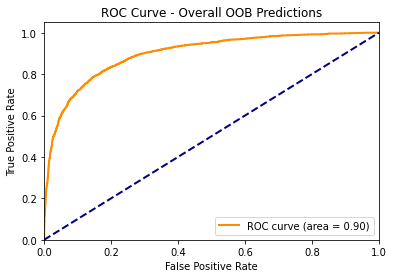

In [310]:
# ROC Curve
# Example 1 -- Overall results
fpr, tpr, thresholds = roc_curve(df_predictions[outcome_var], df_predictions['predict_changed'])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Overall OOB Predictions')
plt.legend(loc="lower right");

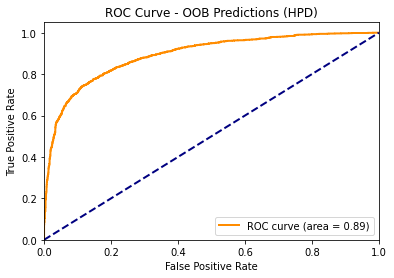

In [311]:
# ROC Curve
# Example 2 -- Overall results (Specific Subgroup)
df_subset = df_predictions.loc[df_predictions['cluster2019_base'] == 1]

fpr, tpr, thresholds = roc_curve(df_subset[outcome_var], df_subset['predict_changed'])
roc_auc = auc(fpr, tpr)

# Plotting
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - OOB Predictions (HPD)')
plt.legend(loc="lower right");

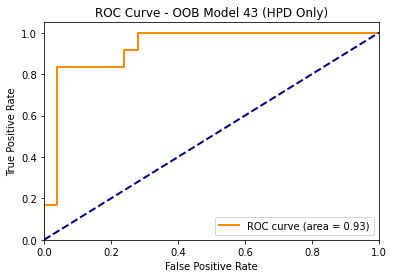

In [312]:
# Example 4 -- Specific Model + Subgroup
# May error for LPA -- True Positive score of 0
model_idx = 43
df_subset = df_predictions.loc[df_predictions['cluster2019_base'] == 1][37 * n : 37 * (n+1)]

fpr, tpr, thresholds = roc_curve(df_subset[outcome_var], df_subset['predict_changed'])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - OOB Model {model_idx} (HPD Only)')
plt.legend(loc="lower right");

### Tree Visualization

In [156]:
# SET MODEL HERE (Using 37 -- best accuracy as an example)
estimator = model_store[37].estimators_[5]

# SET COLUMNS HERE
cols = X_data.columns.values

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_data.columns.values,
                class_names = ['No Sig Change', 'Sig Change'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'classification_tree.dot', '-o', 'classification_tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'classification_tree.png')


### Feature Importance (Overall)

In [192]:
feature_import = [x[0].feature_importances_ for x in model_store]

# SET COLUMNS HERE
cols = X_data.columns.values

df_feature_import = pd.DataFrame(
    columns = cols,
    data = feature_import)

In [193]:
# TOP 15 ON AVERAGE
# ---------------------------
df_feature_import.mean().sort_values(ascending = False)[:15]

prsleep3_txfap       0.032065
promis_anx7_txfap    0.025158
pri12_txfap          0.024423
csi14_txfap          0.024148
csi21_txfap          0.021183
fdi3_txfap           0.020787
pbq3_txfap           0.020126
promis_anx5_txfap    0.019139
pri13_txfap          0.018754
promis_anx4_txfap    0.018345
prsleep8_txfap       0.017459
pbq14_txfap          0.017254
fdi8_txfap           0.016828
pcsc7_txfap          0.016756
pbq15_txfap          0.016369
dtype: float64